# Frequencies Dancing - with ADF4351
- https://www.analog.com/media/en/technical-documentation/data-sheets/ADF4351.pdf

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', '..', '..', '已完成', 'Bridges', 'bitbucket', 'github', 'codes'], 
         ['..', '..', '..', '..', '..', '..', 'Utilities', 'bitbucket', 'github', 'codes'],
         ['..', '..', '..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from utilities.adapters import peripherals
from signal_generators.adf435x import ADF4351 
from utilities.shift_register import ShiftRegister

import time

Populating the interactive namespace from numpy and matplotlib


## Debug mode?

In [5]:
cls = ADF4351 

cls.DEBUG_MODE_SHOW_BUS_DATA = False         # whether to show bus data. 
cls.DEBUG_MODE_PRINT_REGISTER = False        # whether to print registers.

## Generators

In [6]:
with_hardware_device = True

if with_hardware_device:
    _clk = peripherals.Pin.get_Ftdi_pin(pin_id = 4)
    _data = peripherals.Pin.get_Ftdi_pin(pin_id = 1)
    _ss = peripherals.Pin.get_Ftdi_pin(pin_id = 3) 
    _spi = ShiftRegister(stb_pin = _ss, clk_pin = _clk, data_pin = _data, polarity = 0)
    
else:
    _spi = _ss = None  # using None for testing without actual hardware device.

bus = peripherals.SPI(_spi, _ss)
adf = cls(bus) 

## Three Singals

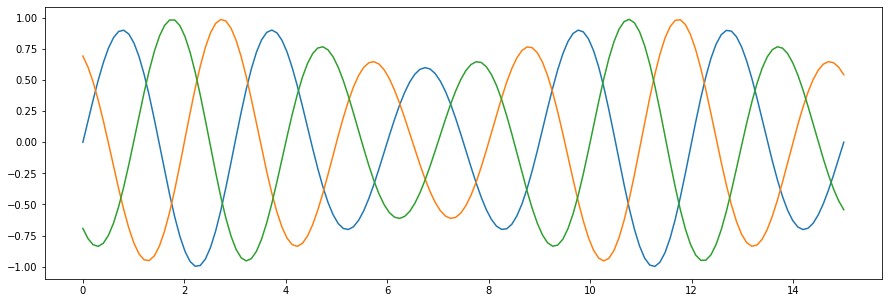

In [7]:
freq = 1/3
fs = 10
Ts = 1/fs

duration = 15
t = np.linspace(0, duration, fs * duration)

n_dancers = 3
ys = np.array([np.sin(2 * np.pi * freq * t + 2*np.pi / n_dancers * i)for i in range(n_dancers)])

freq_amp = freq / 3
amps = (np.sin(2 * np.pi * freq_amp * t) + 4) / 5

ys = ys * amps

plt.figure(figsize = (15, 5))

for i in range(n_dancers):
    plt.plot(t, ys[i]);

In [8]:
adf.init()

In [9]:
freq_center = 1.5e9
bandwidth = 8e6 * 0.8 / 2  # limit of SWFM on SDRuno 
channel_resolution = 10e3

step_max = math.floor(bandwidth / channel_resolution)
step_max

320

392 < 2^12-1 = 4095, so we are good.

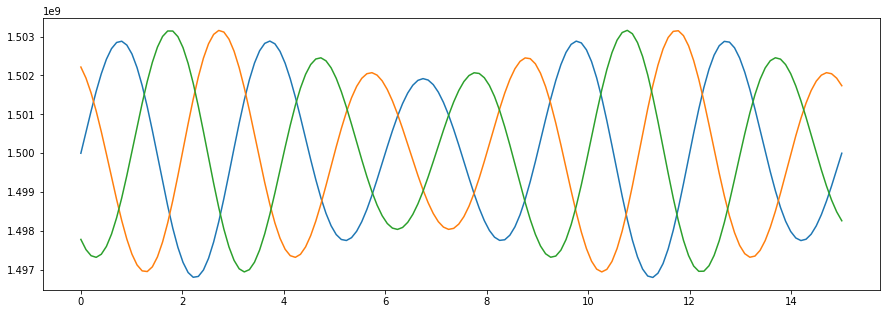

In [10]:
freq_dancers = (freq_center + ys * bandwidth).astype(int)

plt.figure(figsize = (15, 5))
for i in range(3):
    plt.plot(t, freq_dancers[i]);

In [11]:
freq_dancers.T[:10]

array([[1500000000, 1502217025, 1497782974],
       [1500545179, 1501933398, 1497521422],
       [1501084516, 1501551401, 1497364082],
       [1501592636, 1501085337, 1497322025],
       [1502044671, 1500554106, 1497401222],
       [1502417522, 1499980459, 1497602018],
       [1502691096, 1499390024, 1497918879],
       [1502849439, 1498810120, 1498340440],
       [1502881694, 1498268443, 1498849861],
       [1502782838, 1497791673, 1499425488]])

In [14]:
adf.init()
adf.enable(False)

### Frequencies Dancing - with ADF4351

In [ ]:
adf.enable(True)

for row in freq_dancers.T:
    for i in range(n_dancers):
        d, m = divmod(row[i] - freq_center, channel_resolution)
        freq = freq_center + d * channel_resolution
        adf.set_frequency(freq, channel_resolution = channel_resolution)